In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

데이터 불러오기

In [2]:
data_path= "data"
normal_files = glob.glob(data_path+'/normal/'+'*.csv')
anormal_drift_files = glob.glob(data_path+'/anormal_drift/'+'*.csv')
anormal_erratic_files = glob.glob(data_path+'/anormal_erratic/'+'*.csv')
anormal_hardover_files = glob.glob(data_path+'/anormal_hardover/'+'*.csv')
anormal_spike_files = glob.glob(data_path+'/anormal_spike/'+'*.csv')
anormal_stuck_files = glob.glob(data_path+'/anormal_stuck/'+'*.csv')

In [3]:
print(normal_files)

['data/normal\\normal_data0.csv', 'data/normal\\normal_data1.csv', 'data/normal\\normal_data10.csv', 'data/normal\\normal_data100.csv', 'data/normal\\normal_data101.csv', 'data/normal\\normal_data102.csv', 'data/normal\\normal_data103.csv', 'data/normal\\normal_data104.csv', 'data/normal\\normal_data105.csv', 'data/normal\\normal_data106.csv', 'data/normal\\normal_data107.csv', 'data/normal\\normal_data108.csv', 'data/normal\\normal_data109.csv', 'data/normal\\normal_data11.csv', 'data/normal\\normal_data110.csv', 'data/normal\\normal_data111.csv', 'data/normal\\normal_data112.csv', 'data/normal\\normal_data113.csv', 'data/normal\\normal_data114.csv', 'data/normal\\normal_data115.csv', 'data/normal\\normal_data116.csv', 'data/normal\\normal_data117.csv', 'data/normal\\normal_data118.csv', 'data/normal\\normal_data119.csv', 'data/normal\\normal_data12.csv', 'data/normal\\normal_data120.csv', 'data/normal\\normal_data121.csv', 'data/normal\\normal_data122.csv', 'data/normal\\normal_data1

In [4]:
def dataReader(path_names):
    data_n = pd.DataFrame() #판다스의 데이터프레임 형태로 프레임 생성
    for i in path_names:
        low_data = pd.read_csv(i)# 판다스 형태로 읽음, 한csv파일씩 읽기 떄문에 다음 라인에서 하나로 합침
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

In [5]:
normal_datas = dataReader(normal_files)
drift_datas = dataReader(anormal_drift_files)
erratic_datas = dataReader(anormal_erratic_files)
hardover_datas = dataReader(anormal_hardover_files)
spike_datas = dataReader(anormal_spike_files)
stuck_datas = dataReader(anormal_stuck_files)

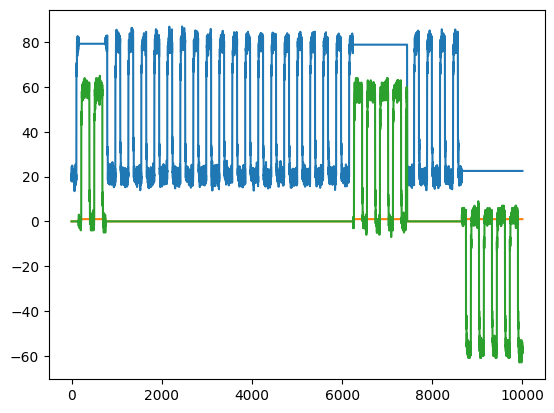

In [6]:
import matplotlib.pyplot as plt

plt.plot(stuck_datas[0:10000])

LSTM 쓸 수 있게 데이터 shape 변경

In [7]:
def Xy_to_XyNtime(X,ntime_in,ntime_out): #X변형할 시계열 데이터 n_time_in 만큼 하나의 input으로 봄, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_in -ntime_out + 1
    X_ntime = [0 for _ in range(nsample)]
    for i in range(nsample):
        X_ntime[i] = X[i:i+ntime_in]
    X_train = np.reshape(X_ntime,(nsample,ntime_in,1)) #2차원 배열을 3차원 배열으로
    print(X_train.shape)
    y_nfuture = [0 for _ in range(nsample)]
    for i in range(nsample):
        y_nfuture[i] = X[i+ntime_in:i+ntime_in+ntime_out]
    y_train = np.array(y_nfuture)
    print(y_train.shape)
    return X_train,y_train

In [ ]:
n_time_in = 10
ntime_out = 1

In [8]:
X_train, y_train = Xy_to_XyNtime(normal_datas['value'],n_time_in,ntime_out)

(4031990, 10, 1)
(4031990, 1)


Train

In [9]:
from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras.models import Sequential

LSTM_AE_model = Sequential()

LSTM_AE_model.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(ntime_out))

LSTM_AE_model.compile(loss="mean_squared_error",optimizer='adam')

In [10]:
LSTM_AE_model.fit(X_train, y_train, epochs=1, batch_size=100, verbose=0)

Test

In [45]:
test_data = hardover_datas

In [46]:
X_test,y_test =Xy_to_XyNtime(test_data['value'][:10000],n_time_in,ntime_out)

(9990, 10, 1)
(9990, 1)


In [47]:
y_predict = LSTM_AE_model.predict(X_test,verbose=0)
y_predict.shape

(9990, 1)

In [71]:
test_size = len(y_predict)

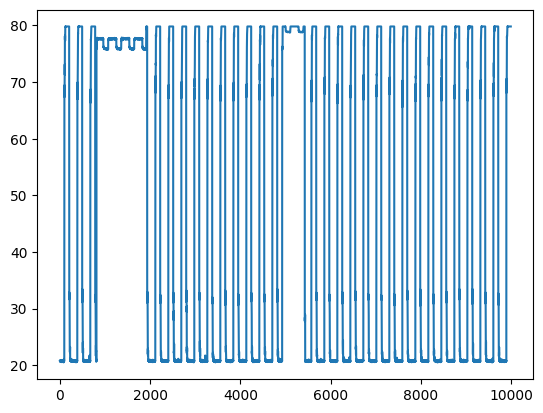

In [72]:
plt.plot(y_predict[ntime_out:test_size])

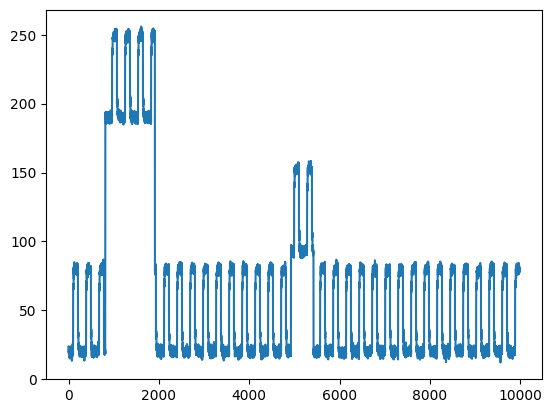

In [73]:
plt.plot(y_test[:test_size-ntime_out])

In [75]:
def MSE(target,predict):
    return (1.0/2.0)*(target-predict)**2

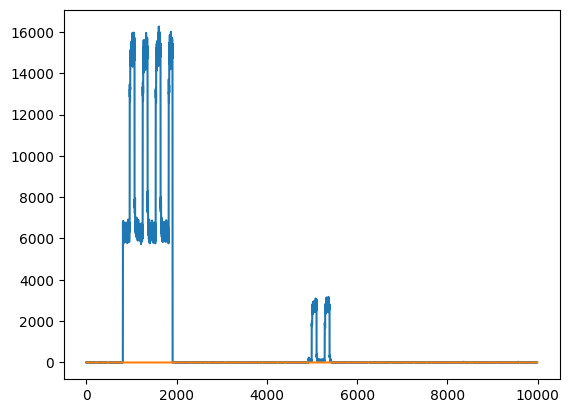

In [76]:
plt.plot(MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
#plt.plot(y_test[:test_size-ntime_out]-y_predict[ntime_out:test_size])
plt.plot(test_data['error'][n_time_in:test_size])
#plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값

In [60]:
def over_num(thresold,np_list):
    for i in range(len(np_list)):
        if(np_list[i]>= thresold):
            print(i)
over_num(100,y_test[:test_size-ntime_out]-y_predict[ntime_out:test_size])

811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048

In [62]:
over_num(1,np.array(test_data['error'][n_time_in:test_size]))

811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048